In [ ]:
# this mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

FOLDERNAME = 'acmlab/teamswag/incomeproject'
assert FOLDERNAME is not None, "[!] Enter the foldername."

import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

%cd /content/drive/My\ Drive/$FOLDERNAME/

Mounted at /content/drive
/content/drive/My Drive/acmlab/teamswag/incomeproject


In [ ]:
# Importing the standard ML libraries
%reload_ext autoreload
%autoreload 2

import pandas as pd                     # to process our data
import matplotlib.pyplot as plt         # graphing
import numpy as np                      # matrices
import torch
import torchvision                      # for working with images
import random
from torchvision import transforms, utils, datasets
from torch.utils.data import Dataset

import os
from PIL import Image
from webmercator import *
from util import *

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')


# Data Pre-proccessing:

In [ ]:
income_data = pd.read_csv("16zpallnoagi.csv")
income_data = income_data[['ZIPCODE', 'N1', 'A02650']]
income_data = income_data[(income_data['ZIPCODE'] > 90000) & (income_data['ZIPCODE'] < 93000)] # filter LA zips
print(income_data)

ziplatlon_data = pd.read_csv("ziplatlon.csv", sep=';')
ziplatlon_data = ziplatlon_data[['zip', 'latitude', 'longitude']]
ziplatlon_data = ziplatlon_data[(ziplatlon_data['zip'] > 90000) & (ziplatlon_data['zip'] < 93000)] #filter CA zips
print(ziplatlon_data)

combined_data = pd.merge(left=ziplatlon_data, right=income_data, left_on='zip', right_on='ZIPCODE', sort = 1)
combined_data = combined_data.drop(columns = 'ZIPCODE')
print(combined_data)

      ZIPCODE     N1   A02650
1640    90001  21670   619635
1641    90002  19890   563172
1642    90003  27290   730810
1643    90004  27810  1995586
1644    90005  15850   807743
...       ...    ...      ...
2256    92881  13030  1134543
2257    92882  29600  1859237
2258    92883  13730  1155228
2259    92886  22950  3039266
2260    92887   9850  1374375

[621 rows x 3 columns]
         zip   latitude   longitude
58     92232  33.026203 -115.284581
98     90038  34.089459 -118.328500
99     90063  34.045161 -118.186500
100    92709  33.640302 -117.769442
171    92693  33.555323 -117.564000
...      ...        ...         ...
43082  92240  33.952303 -116.508040
43083  92292  33.752886 -116.055617
43135  92702  33.640302 -117.769442
43136  92834  33.640302 -117.769442
43148  90070  33.786594 -118.298662

[1106 rows x 3 columns]
       zip   latitude  longitude     N1   A02650
0    90001  33.972914 -118.24878  21670   619635
1    90002  33.948315 -118.24845  19890   563172
2    90003  

In [ ]:
zoom = 14 #constant defining zoom

path = '/content/drive/My Drive/acmlab/teamswag/incomeproject/imagery'
# Store the image file names in a list as long as they are jpgs
train_images = [f for f in os.listdir(path) if os.path.splitext(f)[-1] == '.jpg']
print(train_images)

tiles_data = pd.DataFrame()
images = []
lats = []
longs = []
zip = []
longInc = 1.0/45
latInc = 0.8/44
averageincome = []
for image in train_images:    
    # get x/y coordinates from name
    parts = image.split('.')[0].split('_')
    if (int(parts[0]) == zoom):
        images.append(image)
        x1=int(parts[1])-2794
        y1=int(parts[2])-6528
        lats.append(34.3-(y1+1)*latInc)
        longs.append(-118.6+x1*longInc)
        zip.append(0)
        averageincome.append(0)

tiles_data['tile'] = images
tiles_data['latitude'] = lats
tiles_data['longitude'] = longs
tiles_data['zip'] = zip
tiles_data['avg income'] = averageincome
print(tiles_data)

['14_2800_6556.jpg', '14_2806_6532.jpg', '14_2834_6533.jpg', '14_2820_6531.jpg', '14_2826_6550.jpg', '14_2807_6534.jpg', '14_2797_6555.jpg', '14_2804_6529.jpg', '14_2823_6552.jpg', '14_2805_6550.jpg', '14_2810_6528.jpg', '14_2825_6553.jpg', '14_2797_6532.jpg', '14_2800_6531.jpg', '14_2834_6530.jpg', '14_2828_6532.jpg', '14_2808_6555.jpg', '14_2804_6532.jpg', '14_2812_6539.jpg', '14_2825_6529.jpg', '14_2830_6529.jpg', '14_2837_6551.jpg', '14_2814_6529.jpg', '14_2804_6552.jpg', '14_2797_6538.jpg', '14_2827_6554.jpg', '14_2836_6531.jpg', '14_2809_6532.jpg', '14_2795_6553.jpg', '14_2821_6528.jpg', '14_2795_6540.jpg', '14_2800_6528.jpg', '14_2799_6529.jpg', '14_2795_6530.jpg', '14_2811_6530.jpg', '14_2832_6530.jpg', '14_2803_6530.jpg', '14_2801_6532.jpg', '14_2804_6537.jpg', '14_2826_6536.jpg', '14_2813_6537.jpg', '14_2801_6556.jpg', '14_2802_6528.jpg', '14_2805_6531.jpg', '14_2833_6528.jpg', '14_2826_6529.jpg', '14_2818_6529.jpg', '14_2818_6530.jpg', '14_2817_6530.jpg', '14_2829_6537.jpg',

In [ ]:
def getDistance(lat1, long1, lat2, long2):
    return ((lat1-lat2)**2+(long1-long2)**2)**0.5

In [ ]:
#Assign center of zip code to tile it's in.
print(combined_data)
print(tiles_data)
#assign zip code to tile that has center
for i, j in combined_data.iterrows():
    zip = int(j[0])
    latitude = j[1]
    longitude = j[2]
    tiles_data.loc[(tiles_data['latitude'] <= latitude) & (tiles_data['latitude'] + latInc > latitude) & (tiles_data['longitude'] <= longitude) & (tiles_data['longitude'] + longInc > longitude), 'zip'] = zip
print(tiles_data[tiles_data['zip'] != 0])



       zip   latitude  longitude     N1   A02650
0    90001  33.972914 -118.24878  21670   619635
1    90002  33.948315 -118.24845  19890   563172
2    90003  33.962714 -118.27600  27290   730810
3    90004  34.077110 -118.30755  27810  1995586
4    90005  34.058911 -118.30848  15850   807743
..     ...        ...        ...    ...      ...
608  92881  33.839516 -117.53581  13030  1134543
609  92882  33.866555 -117.59167  29600  1859237
610  92883  33.771548 -117.47884  13730  1155228
611  92886  33.888062 -117.80407  22950  3039266
612  92887  33.883223 -117.73856   9850  1374375

[613 rows x 5 columns]
                  tile   latitude   longitude  zip  avg income
0     14_2800_6556.jpg  33.772727 -118.466667    0           0
1     14_2806_6532.jpg  34.209091 -118.333333    0           0
2     14_2834_6533.jpg  34.190909 -117.711111    0           0
3     14_2820_6531.jpg  34.227273 -118.022222    0           0
4     14_2826_6550.jpg  33.881818 -117.888889    0           0
...       

In [ ]:
#assign closest zip code for each land tile
for a, b in tiles_data.iterrows():
    latTile = b[1]+latInc/2
    longTile = b[2]+longInc/2
    if (getElevation(latTile, longTile) != 0):
        minZip = combined_data.iat[0, 0]
        minLat = combined_data.iat[0, 1]
        minLong = combined_data.iat[0, 2]
        minDistance = getDistance(latTile, longTile, minLat, minLong)
        cont = 1
        for i, j in combined_data.iterrows():
            curZip = int(j[0])
            curZip_data = combined_data[(combined_data['zip'] == curZip)]
            curLat = curZip_data.iat[0, 1]
            curLong = curZip_data.iat[0, 2]
            curDistance = getDistance(latTile, longTile, curLat, curLong)
            if (curDistance < minDistance):
                minDistance = curDistance
                minZip = curZip
            
        tiles_data.loc[(tiles_data['latitude'] <= latTile) & (tiles_data['latitude'] + latInc > latTile) & (tiles_data['longitude'] <= longTile) & (tiles_data['longitude'] + longInc > longTile), 'zip'] = minZip
print(tiles_data[tiles_data['zip'] != 0])

                  tile   latitude   longitude    zip  avg income
1     14_2806_6532.jpg  34.209091 -118.333333  91504           0
2     14_2834_6533.jpg  34.190909 -117.711111  91759           0
3     14_2820_6531.jpg  34.227273 -118.022222  91024           0
4     14_2826_6550.jpg  33.881818 -117.888889  92831           0
5     14_2807_6534.jpg  34.172727 -118.311111  91501           0
...                ...        ...         ...    ...         ...
1975  14_2808_6530.jpg  34.245455 -118.288889  91042           0
1976  14_2829_6554.jpg  33.809091 -117.822222  92861           0
1977  14_2802_6530.jpg  34.245455 -118.422222  91331           0
1978  14_2805_6553.jpg  33.827273 -118.355556  90503           0
1979  14_2815_6552.jpg  33.845455 -118.133333  90713           0

[1462 rows x 5 columns]


In [ ]:
#print (tiles_data)
#distribute population/income
for i, j in combined_data.iterrows():
    zip = int(j[0])
    avgIncome = j[4]/j[3]
    tiles_data.loc[tiles_data['zip'] == zip, 'avg income'] = avgIncome

tiles_data = tiles_data[tiles_data['avg income'] != 0]

print(tiles_data)

                  tile   latitude   longitude    zip  avg income
1     14_2806_6532.jpg  34.209091 -118.333333  91504   78.980048
2     14_2834_6533.jpg  34.190909 -117.711111  91759   75.856522
3     14_2820_6531.jpg  34.227273 -118.022222  91024  125.569399
4     14_2826_6550.jpg  33.881818 -117.888889  92831   71.769890
5     14_2807_6534.jpg  34.172727 -118.311111  91501   75.296158
...                ...        ...         ...    ...         ...
1975  14_2808_6530.jpg  34.245455 -118.288889  91042   59.230114
1976  14_2829_6554.jpg  33.809091 -117.822222  92861  233.749123
1977  14_2802_6530.jpg  34.245455 -118.422222  91331   35.610863
1978  14_2805_6553.jpg  33.827273 -118.355556  90503   94.787718
1979  14_2815_6552.jpg  33.845455 -118.133333  90713   74.717705

[1462 rows x 5 columns]


In [ ]:
print(tiles_data['avg income'])

1        78.980048
2        75.856522
3       125.569399
4        71.769890
5        75.296158
           ...    
1975     59.230114
1976    233.749123
1977     35.610863
1978     94.787718
1979     74.717705
Name: avg income, Length: 1462, dtype: float64


In [ ]:
tiles_data.to_csv('tiles_data.csv',index=True)  # save to csv files to make our lives a lot easier

# Implementing CNN's:
Initialize training and testing dataset (example below)

In [ ]:
tiles_data = pd.read_csv("tiles_data.csv", sep=',')
tiles_data = tiles_data.drop(columns = 'Unnamed: 0')
print(tiles_data)

                  tile   latitude   longitude    zip  avg income
0     14_2806_6532.jpg  34.209091 -118.333333  91504   78.980048
1     14_2834_6533.jpg  34.190909 -117.711111  91759   75.856522
2     14_2820_6531.jpg  34.227273 -118.022222  91024  125.569399
3     14_2826_6550.jpg  33.881818 -117.888889  92831   71.769890
4     14_2807_6534.jpg  34.172727 -118.311111  91501   75.296158
...                ...        ...         ...    ...         ...
1457  14_2808_6530.jpg  34.245455 -118.288889  91042   59.230114
1458  14_2829_6554.jpg  33.809091 -117.822222  92861  233.749123
1459  14_2802_6530.jpg  34.245455 -118.422222  91331   35.610863
1460  14_2805_6553.jpg  33.827273 -118.355556  90503   94.787718
1461  14_2815_6552.jpg  33.845455 -118.133333  90713   74.717705

[1462 rows x 5 columns]


In [ ]:
class CustomDataSet(Dataset):
    def __init__(self, main_dir, transform):
        self.main_dir = main_dir
        self.transform = transform
        self.all_imgs = self.get_images()
        self.all_labels = self.get_labels()

    def __getitem__(self, idx):
        img_loc = os.path.join(self.main_dir, self.all_imgs[idx])
        image = Image.open(img_loc).convert("RGB")
        tensor_image = self.transform(image)
        label = self.all_labels[idx]
        return tensor_image, label

    def __len__(self):
        return len(self.all_imgs)

    def get_labels(self):
        return tiles_data['avg income'].tolist()

    def get_images(self):
        return tiles_data['tile'].tolist()

transform_aug = torchvision.transforms.Compose([
                              torchvision.transforms.RandomHorizontalFlip(p=0.5),
                              torchvision.transforms.RandomVerticalFlip(p=0.5),
                              torchvision.transforms.RandomRotation(180),
                              torchvision.transforms.ToTensor()])
transform_none = torchvision.transforms.ToTensor()

In [ ]:
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

img_folder_path = '/content/drive/My Drive/acmlab/teamswag/incomeproject/imagery'

dset1 = CustomDataSet(img_folder_path, transform = transform_aug)
dset2 = CustomDataSet(img_folder_path, transform = transform_none)

all_indices=[]
train_indices=[]
for i in range(0, 1462):
    all_indices.append(i)
train_indices=random.sample(all_indices, k=1412)
test_indices = all_indices
print(train_indices, test_indices)
for x in train_indices:
    test_indices.remove(x)
print(test_indices)

train_sampler = SubsetRandomSampler(train_indices)
test_sampler = SubsetRandomSampler(test_indices)
batch_size = 64
train_loader = torch.utils.data.DataLoader(dset1, batch_size=batch_size, sampler=train_sampler)
test_loader = torch.utils.data.DataLoader(dset2, batch_size=batch_size, sampler=test_sampler)

[346, 660, 287, 203, 78, 254, 958, 219, 760, 1292, 532, 331, 1390, 131, 650, 704, 509, 841, 478, 647, 954, 1230, 495, 113, 166, 671, 636, 592, 1392, 1303, 728, 939, 479, 334, 1380, 1459, 945, 1299, 1050, 165, 803, 562, 36, 468, 112, 418, 685, 1300, 1375, 606, 1306, 736, 258, 1109, 594, 1234, 859, 57, 1438, 1427, 272, 72, 1268, 865, 912, 1138, 189, 1101, 793, 869, 477, 823, 198, 1288, 870, 979, 1060, 964, 1224, 1269, 564, 221, 354, 238, 280, 427, 1237, 373, 1201, 305, 304, 1378, 1227, 1298, 1120, 600, 687, 1295, 1350, 465, 213, 1244, 352, 1243, 413, 504, 610, 259, 1024, 245, 710, 1418, 1277, 262, 501, 356, 1335, 705, 1226, 456, 409, 1044, 1103, 1443, 321, 994, 1245, 808, 1409, 100, 847, 882, 430, 169, 1031, 730, 733, 1273, 442, 1346, 398, 996, 1316, 1167, 277, 54, 471, 999, 362, 1210, 1202, 874, 1414, 714, 414, 631, 834, 1416, 345, 567, 1178, 598, 297, 271, 779, 550, 734, 241, 1087, 32, 1446, 1208, 881, 1071, 1263, 1246, 1, 1320, 1169, 1098, 106, 1191, 1033, 1139, 372, 1330, 33, 1144, 2

<PIL.Image.Image image mode=RGB size=256x256 at 0x7F4C30E81A20>
tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])


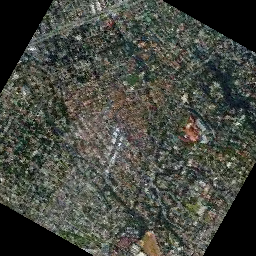

In [ ]:
i = 1000
image, label = dset1[i]
image = np.moveaxis(image.numpy(), 0, -1)
image = (image * 255).astype(np.uint8) # to preview, needs to be ints
display(Image.fromarray(image).convert("RGB"))


### Defining convolutional neural network:

Example architecture below
-  10 channels of 5x5 convolutions
-  Max pool with stride 2 and 2x2 kernels
-  20 channels of 5x5 convolutions
-  Max pool with stride 2 and 2x2 kernels
-  Fully connected (linear) layer with 50 outputs
-  Fully connected (linear) layer

Convolutional layers may be created with nn.Conv2d(in_channels, out_channels, kernel_size). Pooling layers are available as F.max_pool2d(kernel_size, stride).


We need to figure out  the size of the image after the last max pool layer in order to convert it to pass into the linear layer, which expects a tensor of shape (batch_size, flattened_image_length). 
-  Use x.view(new dimensions) to reshape a tensor into new dimensions 
(example: if x is of shape (4, 3, 3) and you want to change it to be (4, 9), you can do x.view(-1, 9).)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class ConvolutionalNeuralNet(nn.Module):
  def __init__(self):
    super(ConvolutionalNeuralNet, self).__init__()
    self.dropout = torch.nn.Dropout(p=0.5)
    self.conv1 = nn.Conv2d(3, 64, 3, stride = 4, padding = 1) 
    self.pool1 = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(64, 128, 7, stride = 2, padding = 3)
    self.pool2 = nn.MaxPool2d(2, 2)
    self.conv3 = nn.Conv2d(128, 256, 5, stride = 1, padding = 2) 
    self.pool3 = nn.MaxPool2d(2, 2)
    self.conv4 = nn.Conv2d(256, 512, 5, stride = 1, padding = 2) 
    self.pool4 = nn.MaxPool2d(2, 2)
    self.conv5 = nn.Conv2d(512, 1024, 5, stride = 1, padding = 2) 
    self.pool5 = nn.MaxPool2d(2, 2)
    #self.conv6 = nn.Conv2d(1024, 2048, 7, stride = 2, padding = 3) 
    #self.pool6 = nn.MaxPool2d(2, 2)
    #self.conv7 = nn.Conv2d(2048, 4096, 7, stride = 2, padding = 3) 
    #self.pool7 = nn.MaxPool2d(2, 2)
    #self.conv8 = nn.Conv2d(4096, 8192, 7, stride = 2, padding = 3) 
    #self.pool8 = nn.MaxPool2d(2, 2)
    self.fc1 = nn.Linear(1024 * 1 * 1, 2000)
    self.fc2 = nn.Linear(2000, 1)
  
  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = x.dropout()
    x = self.pool1(x)
    x = F.relu(self.conv2(x))
    x = x.dropout()
    x = self.pool2(x)
    x = F.relu(self.conv3(x))
    x = x.dropout()
    x = self.pool3(x)
    x = F.relu(self.conv4(x))
    x = x.dropout()
    x = self.pool4(x)
    x = F.relu(self.conv5(x))
    x = x.dropout()
    x = self.pool5(x)
    x = x.view(-1, 1024 * 1 * 1) 
    x = self.fc1(x)
    x = self.fc2(x)
    return x

### Train model:

Example below uses Adam optimizer with learning rate .001. It also prints  loss every 100 minibatches, as well as overall loss for every epoch. 

We also use cross entropy loss instead of binary cross entropy loss because we are working with multiple classes. 
We also should be using the dataloader to train in minibatches inside of each epoch.

In [ ]:
cnn_model = ConvolutionalNeuralNet().to(device=device)
criterion = torch.nn.L1Loss()
optimizer = torch.optim.Adam(cnn_model.parameters(), lr = 0.002, weight_decay = 0.05) 


cont = 0
min_loss = 10000000
patience = 0
for epoch in range(300):
    epoch_loss = 0
    for batch_idx, (images, labels) in enumerate(train_loader):
        # Load the images and labels on the GPU
        images = images.to(device=device)
        labels = labels.to(device=device)
        
        optimizer.zero_grad()                 # resets the information from last time
        pred_labels = cnn_model(images).squeeze()       # calculates the predictions
        pred_labels = torch.clamp(pred_labels, 0)
        loss = criterion(pred_labels, labels)
        writer.add_scalar("Loss/train", loss, epoch)
        
        loss.backward()                       # gradient descent, part 1
        torch.nn.utils.clip_grad_norm(cnn_model.parameters(), 10)  # gradient clipping(linear reg can have infinite gradients)
        optimizer.step()                      # gradient descent, part 2

        epoch_loss += loss.item() / labels.shape[0]

        #if batch_idx % 1 == 0:
            #print(f"Epoch {epoch}, batch {batch_idx}: {loss}")
    print(f"Epoch {epoch}: {epoch_loss}")
    if epoch_loss < min_loss:
        torch.save(cnn_model, 'best_model')
        patience = 0
        min_loss = epoch_loss
        print(min_loss)
    else:
        patience += 1
        print(patience)
    if (patience > 19):
        print()
        break;
    
cnn_model = torch.load('best_model')

AttributeError: ignored

Check accuracy on test dataset:

Average absolute error of the network on the 50 test images: 63.61449162271557
Max error:  574.2338470137569 . Actual, predicted values:  634.3662971175166 60.132450103759766


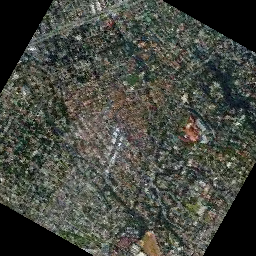

12
Min error:  0.33880268977238615 . Actual, predicted values:  62.97512019230769 63.31392288208008
Average percent error of the network on the 50 test images: 34.97660453813176%
Max percent error:  90.52086304442807 . Actual, predicted values:  634.3662971175166 60.132450103759766
Min percent error:  0.5379945107492948 . Actual, predicted values:  62.97512019230769 63.31392288208008


In [ ]:
totalError = 0
totalPercentError = 0
totalNums = 0
maxError = 0
maxPercentError = 0
minError = 10000
minPercentError = 1000
with torch.no_grad():
  for images, labels in test_loader:
    outputs = cnn_model(images.to(device=device))
    labels = labels.to(device=device)
    predicted = torch.max(outputs.data, dim=1)
    for i in range (0, labels.size(0)):
        error = abs(predicted[0][i].item() - labels[i].item())
        percentError = abs(100*(predicted[0][i].item() - labels[i].item())/labels[i].item())
        if error > maxError:
            maxError = error
            maxErrorActual = labels[i].item()
            maxErrorPredicted = predicted[0][i].item()
            
            maxImage = images[i] # image shape: [3, 256, 256]
            maxIndex = i

        if percentError > maxPercentError:
            maxPercentError = percentError
            maxPercentErrorActual = labels[i].item()
            maxPercentErrorPredicted = predicted[0][i].item()
        if error < minError:
            minError = error
            minErrorActual = labels[i].item()
            minErrorPredicted = predicted[0][i].item()
        if percentError < minPercentError:
            minPercentError = percentError
            minPercentErrorActual = labels[i].item()
            minPercentErrorPredicted = predicted[0][i].item()
        totalError += abs(predicted[0][i].item() - labels[i].item())
        totalPercentError += abs(100*(predicted[0][i].item() - labels[i].item())/labels[i].item())
    totalNums += labels.size(0)

print(f'Average absolute error of the network on the {totalNums} test images: {totalError/totalNums}')
print("Max error: ", maxError,". Actual, predicted values: ", maxErrorActual, maxErrorPredicted)
maxImage = np.moveaxis(maxImage.numpy(), 0, -1) # image shape: [256, 256, 3]
maxImage = (maxImage * 255).astype(np.uint8) # to preview, needs to be ints
display(Image.fromarray(image).convert("RGB"))
print(maxIndex)
print("Min error: ", minError,". Actual, predicted values: ", minErrorActual, minErrorPredicted)
print(f'Average percent error of the network on the {totalNums} test images: {totalPercentError/totalNums}%')
print("Max percent error: ", maxPercentError,". Actual, predicted values: ", maxPercentErrorActual, maxPercentErrorPredicted)
print("Min percent error: ", minPercentError,". Actual, predicted values: ", minPercentErrorActual, minPercentErrorPredicted)

In [ ]:
def predict(path = None):
    img_loc = path
    print(path)
    image = Image.open(img_loc).convert("RGB")
    tensor_image = transform_none(image).unsqueeze(0)
    print(tensor_image)
    return cnn_model(tensor_image.to(device=device)).squeeze().item()
predict('/content/drive/My Drive/acmlab/teamswag/incomeproject/imagery/14_2794_6528.jpg')

/content/drive/My Drive/acmlab/teamswag/incomeproject/imagery/14_2794_6528.jpg
tensor([[[[0.6353, 0.6157, 0.5882,  ..., 0.6314, 0.6471, 0.6196],
          [0.6549, 0.6157, 0.5882,  ..., 0.6078, 0.6235, 0.6039],
          [0.5843, 0.5686, 0.5804,  ..., 0.5882, 0.6078, 0.5922],
          ...,
          [0.1765, 0.2235, 0.2196,  ..., 0.5608, 0.4784, 0.5882],
          [0.2667, 0.1529, 0.1373,  ..., 0.5686, 0.5255, 0.5647],
          [0.3922, 0.0902, 0.0078,  ..., 0.5882, 0.4824, 0.6078]],

         [[0.5686, 0.5490, 0.5216,  ..., 0.5255, 0.5294, 0.5020],
          [0.5882, 0.5490, 0.5216,  ..., 0.5020, 0.5176, 0.4980],
          [0.5176, 0.5020, 0.5137,  ..., 0.4824, 0.5020, 0.4863],
          ...,
          [0.2039, 0.2510, 0.2392,  ..., 0.5451, 0.4745, 0.5843],
          [0.2902, 0.1765, 0.1647,  ..., 0.5529, 0.5216, 0.5608],
          [0.4275, 0.1137, 0.0353,  ..., 0.5725, 0.4784, 0.6039]],

         [[0.4510, 0.4314, 0.4039,  ..., 0.4118, 0.4196, 0.3922],
          [0.4706, 0.4314, 0.

65.15569305419922